In [1]:
!wget https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2017/04/a943287.csv

--2019-02-26 05:38:13--  https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2017/04/a943287.csv
Resolving d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)... 54.192.73.68, 54.192.73.51, 54.192.73.151, ...
Connecting to d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)|54.192.73.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7847932 (7.5M) [application/octet-stream]
Saving to: ‘a943287.csv’

a943287.csv         100%[===================>]   7.48M  3.77MB/s    in 2.0s    

2019-02-26 05:38:16 (3.77 MB/s) - ‘a943287.csv’ saved [7847932/7847932]



In [0]:
import pandas as pd, numpy as np
from skimage import io

In [3]:
data = pd.read_csv('/content/a943287.csv')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50


In [0]:
data_male = data[data['please_select_the_gender_of_the_person_in_the_picture']=="male"].reset_index(drop='index')
data_female = data[data['please_select_the_gender_of_the_person_in_the_picture']=="female"].reset_index(drop='index')

In [5]:
final_data = pd.concat([data_male[:1000],data_female[:1000]],axis=0).reset_index(drop='index')
final_data.shape

(2000, 10)

# Scenario 1: Big images

In [0]:
x = []
y = []
for i in range(final_data.shape[0]):
  if(i%100==0):
    print(i)
  try:
    image = io.imread(final_data.loc[i]['image_url'])
    if(image.shape==(300,300,3)):
      x.append(image)
      y.append(final_data.loc[i]['please_select_the_gender_of_the_person_in_the_picture'])
  except:
    continue

In [0]:
x2 = []
y2 = []
for i in range(len(x)):
  x2.append(x[i])
  img_label = np.where(y[i]=="male",1,0)
  y2.append(img_label)

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

Using TensorFlow backend.


In [0]:
x2 = np.array(x2)

In [0]:
x2 = x2.reshape(x2.shape[0],x2.shape[1],x2.shape[2],3)

In [0]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(300,300,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 256)       0         
_________________________________________________________________
conv

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
X = np.array(x2)/255
Y = np.array(y2)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [0]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1593, 300, 300, 3) (177, 300, 300, 3) (1593,) (177,)


In [0]:
np.max(X_train)

1.0

In [0]:
history = model.fit(X_train, y_train, batch_size=32,epochs=10,verbose=1,validation_data = (X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 1593 samples, validate on 177 samples
Epoch 1/10
1593/1593 [==============================] - 42s 26ms/step - loss: 7.5936 - acc: 0.5135 - val_loss: 7.8314 - val_acc: 0.5141
Epoch 2/10
1593/1593 [==============================] - 31s 20ms/step - loss: 7.8820 - acc: 0.5110 - val_loss: 7.8314 - val_acc: 0.5141
Epoch 3/10
1593/1593 [==============================] - 31s 20ms/step - loss: 7.8820 - acc: 0.5110 - val_loss: 7.8314 - val_acc: 0.5141
Epoch 4/10
1593/1593 [==============================] - 31s 20ms/step - loss: 7.8820 - acc: 0.5110 - val_loss: 7.8314 - val_acc: 0.5141
Epoch 5/10
1593/1593 [==============================] - 31s 20ms/step - loss: 7.8820 - acc: 0.5110 - val_loss: 7.8314 - val_acc: 0.5141
Epoch 6/10
1593/1593 [==============================] - 31s 20ms/step - loss: 7.8820 - acc: 0.5110 - val_loss: 7.8314 - val_acc: 0.5141
Epoch 7/10
1593/1593 [==============================] - 31s 20ms/step - loss: 7.8820 - ac

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


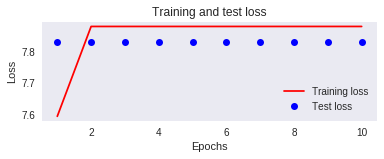

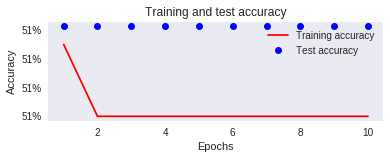

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'bo', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Scenario 2: Small images

In [0]:
import cv2
x2 = []
y2 = []
for i in range(len(x)):
  img = cv2.resize(x[i],(50,50))
  x2.append(img)
  img_label = np.where(y[i]=="male",1,0)
  y2.append(img_label)

In [0]:
np.array(x2).shape

(1770, 50, 50, 3)

In [0]:
x2 = np.array(x2)
x2 = x2.reshape(x2.shape[0],x2.shape[1],x2.shape[2],3)

In [0]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 512)         1180160   
__________

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X = np.array(x2)/255
Y = np.array(y2)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

history = model.fit(X_train, y_train, batch_size=32,epochs=10,verbose=1,validation_data = (X_test, y_test))

Train on 1593 samples, validate on 177 samples
Epoch 1/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.6977 - acc: 0.5009 - val_loss: 0.6925 - val_acc: 0.5367
Epoch 2/10
1593/1593 [==============================] - 1s 898us/step - loss: 0.6855 - acc: 0.5706 - val_loss: 0.6895 - val_acc: 0.5424
Epoch 3/10
1593/1593 [==============================] - 1s 900us/step - loss: 0.6454 - acc: 0.6466 - val_loss: 0.6667 - val_acc: 0.6102
Epoch 4/10
1593/1593 [==============================] - 1s 890us/step - loss: 0.5860 - acc: 0.6786 - val_loss: 0.6249 - val_acc: 0.6497
Epoch 5/10
1593/1593 [==============================] - 1s 896us/step - loss: 0.5474 - acc: 0.7188 - val_loss: 0.5833 - val_acc: 0.6723
Epoch 6/10
1593/1593 [==============================] - 1s 896us/step - loss: 0.4925 - acc: 0.7558 - val_loss: 0.5855 - val_acc: 0.6667
Epoch 7/10
1593/1593 [==============================] - 1s 896us/step - loss: 0.4269 - acc: 0.7884 - val_loss: 0.5536 - val_acc: 0.7062
Epo

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


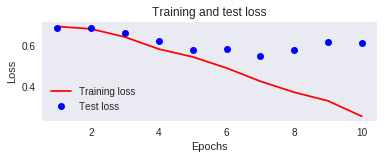

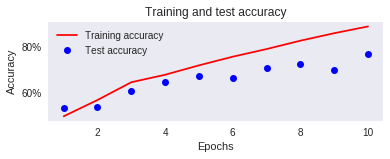

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'bo', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Aggressive pooling on big images

In [0]:
x2 = []
y2 = []
for i in range(len(x)):
  x2.append(x[i])
  img_label = np.where(y[i]=="male",1,0)
  y2.append(img_label)

In [0]:
x2 = np.array(x2)
x2 = x2.reshape(x2.shape[0],x2.shape[1],x2.shape[2],3)

In [0]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(300,300,3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 99, 99, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 33, 33, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 33, 33, 256)       295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 512)       1180160   
__________

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X = np.array(x2)/255
Y = np.array(y2)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

history = model.fit(X_train, y_train, batch_size=32,epochs=10,verbose=1,validation_data = (X_test, y_test))

Train on 1593 samples, validate on 177 samples
Epoch 1/10
1593/1593 [==============================] - 17s 11ms/step - loss: 0.7401 - acc: 0.4965 - val_loss: 0.6928 - val_acc: 0.5141
Epoch 2/10
1593/1593 [==============================] - 14s 9ms/step - loss: 0.6933 - acc: 0.5116 - val_loss: 0.6931 - val_acc: 0.5367
Epoch 3/10
1593/1593 [==============================] - 14s 9ms/step - loss: 0.6930 - acc: 0.5122 - val_loss: 0.6882 - val_acc: 0.5763
Epoch 4/10
1593/1593 [==============================] - 14s 9ms/step - loss: 0.6788 - acc: 0.6020 - val_loss: 0.6796 - val_acc: 0.5593
Epoch 5/10
1593/1593 [==============================] - 14s 9ms/step - loss: 0.6612 - acc: 0.6083 - val_loss: 0.6520 - val_acc: 0.6328
Epoch 6/10
1593/1593 [==============================] - 14s 9ms/step - loss: 0.6197 - acc: 0.6541 - val_loss: 0.6476 - val_acc: 0.6045
Epoch 7/10
1593/1593 [==============================] - 14s 9ms/step - loss: 0.6050 - acc: 0.6742 - val_loss: 0.6477 - val_acc: 0.6497
Epoch 8

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


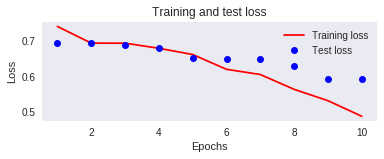

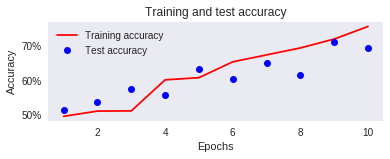

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'bo', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# VGG16 architecture

In [0]:
from keras.applications import vgg16
from keras.utils.vis_utils import plot_model
from keras.applications.vgg16 import preprocess_input
vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(300,300,3))

In [0]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [0]:
import cv2
x2_vgg16 = []
for i in range(len(x)):
    if(i%100 == 0):
      print(i)
    img = x[i]
    img = preprocess_input(img.reshape(1,300,300,3))
    img_new = vgg16_model.predict(img.reshape(1,300,300,3))
    x2_vgg16.append(img_new)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [0]:
x2_vgg16 = np.array(x2_vgg16)
x2_vgg16.shape

(1770, 1, 9, 9, 512)

In [0]:
x2_vgg16= x2_vgg16.reshape(x2_vgg16.shape[0],x2_vgg16.shape[2],x2_vgg16.shape[3],x2_vgg16.shape[4])
x2_vgg16.shape

(1770, 9, 9, 512)

In [0]:
Y = np.array(y2)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x2_vgg16,Y, test_size=0.1, random_state=42)

In [0]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1593, 9, 9, 512) (177, 9, 9, 512) (1593,) (177,)


In [0]:
np.max(X_train)

691.86755

In [0]:
model_vgg16 = Sequential()
model_vgg16.add(Conv2D(512, kernel_size=(3, 3), activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
model_vgg16.add(MaxPooling2D(pool_size=(2, 2)))
model_vgg16.add(Flatten())
model_vgg16.add(Dense(512, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(1, activation='sigmoid'))
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 4,720,129
Trainable params: 4,720,129
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_vgg16.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
np.mean(y_train)

0.48901443816698054

In [0]:
history_vgg16 = model_vgg16.fit(X_train/np.max(X_train), y_train, batch_size=16,epochs=10,verbose=1,validation_data = (X_test/np.max(X_train), y_test))

Train on 1593 samples, validate on 177 samples
Epoch 1/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.3412 - acc: 0.8537 - val_loss: 0.2651 - val_acc: 0.8814
Epoch 2/10
1593/1593 [==============================] - 2s 1ms/step - loss: 0.1218 - acc: 0.9535 - val_loss: 0.3303 - val_acc: 0.8757
Epoch 3/10
1593/1593 [==============================] - 2s 1ms/step - loss: 0.0392 - acc: 0.9881 - val_loss: 0.3896 - val_acc: 0.9040
Epoch 4/10
1593/1593 [==============================] - 2s 1ms/step - loss: 0.0160 - acc: 0.9956 - val_loss: 0.5198 - val_acc: 0.8983
Epoch 5/10
1593/1593 [==============================] - 2s 1ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.6150 - val_acc: 0.8870
Epoch 6/10
1593/1593 [==============================] - 2s 1ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.6530 - val_acc: 0.8927
Epoch 7/10
1593/1593 [==============================] - 2s 1ms/step - loss: 6.9008e-04 - acc: 1.0000 - val_loss: 0.6935 - val_acc: 0.8927
Epoch 8/10


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


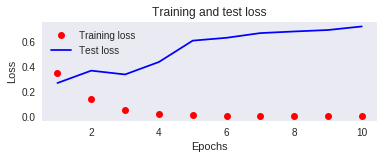

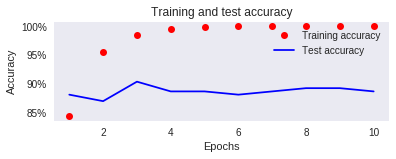

In [0]:
history_dict = history_vgg16.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_vgg16.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_vgg16.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
y_pred = model_vgg16.predict(X_test/np.max(X_train))
y_pred.shape

(177, 1)

In [0]:
np.abs(y_pred.flatten()-y_test)[27]

0.9997755587100983

In [0]:
np.argsort(np.abs(y_pred.flatten()-y_test))

array([  0,  23, 115, 104,  99,  29,  98,  31,  95,  92,  91, 175,  86,
        82,  78,  70,  66,  57,  51, 121, 117, 122, 172, 167, 164, 160,
       159, 150, 149, 147,  20, 146, 138,  13,  15, 130, 128, 126,  47,
       105,  79, 145,  34, 133,  24, 139,  88, 110, 116, 154,  62,  73,
        42,  36, 153,  74,  41,   5,  87,  77,  14, 165, 171,  28,  50,
       140, 162,   6,  17,  52,  69, 144,  75, 152, 120,   3,  76,  12,
        65,  72,  90,  97,  61,  22,  38, 131, 166,  19, 114, 124, 107,
       137, 125, 157, 135, 148, 132,  81,  35, 169,  21,  55,  25, 136,
        49,  11, 129,  53, 127, 142,  84,  56,  58,   7,   8,  59, 170,
       163,  18,  48,  54,  37,  33, 151, 102, 109, 155,   1, 106, 168,
       158,  26, 173,  45,  89,  60,  40, 141, 143,  63,  44,  16, 156,
        30,  67, 101,  10, 123,  68,  43, 174, 176,  94, 103, 112, 119,
        39, 100,  80,   2, 134,  64, 108,  96, 111,  93,  71,   9,  27,
       113,   4,  46,  85, 118,  83,  32, 161])

In [0]:
y_pred2 = np.where(y_pred>0.5,1,0)

In [0]:
from sklearn.model_selection import train_test_split
img_train, img_test, y_train, y_test = train_test_split(x,Y, test_size=0.1, random_state=42)

In [0]:
y_test_char = np.where(y_test==0,'F','M')

In [0]:
y_pred_char = np.where(y_pred>0.5,'M','F')

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


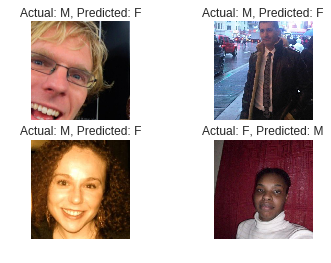

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(221)
plt.imshow(img_test[85])
plt.title('Actual: '+str(y_test_char[85])+', '+'Predicted: '+str((y_pred_char[85][0])))
plt.grid('off')
plt.axis('off')
plt.subplot(222)
plt.title('Actual: '+str(y_test_char[32])+', '+'Predicted: '+str((y_pred_char[32][0])))
plt.imshow(img_test[32])
plt.grid('off')
plt.axis('off')
plt.subplot(223)
plt.title('Actual: '+str(y_test_char[83])+', '+'Predicted: '+str((y_pred_char[83][0])))
plt.imshow(img_test[83])
plt.grid('off')
plt.axis('off')
plt.subplot(224)
plt.title('Actual: '+str(y_test_char[46])+', '+'Predicted: '+str((y_pred_char[46][0])))
plt.imshow(img_test[46])
plt.grid('off')
plt.axis('off')
plt.show()

# VGG19 architecture

In [0]:
from keras.applications import vgg19
from keras.utils.vis_utils import plot_model
from keras.applications.vgg19 import preprocess_input
vgg19_model = vgg19.VGG19(include_top=False, weights='imagenet',input_shape=(300,300,3))

vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [0]:
import cv2
x2 = []
for i in range(len(x)):
    if(i%100 == 0):
      print(i)
    img = x[i]
    img = preprocess_input(img.reshape(1,300,300,3))
    img_new = vgg19_model.predict(img.reshape(1,300,300,3))
    x2.append(img_new)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [0]:
x2 = np.array(x2)
x2.shape

(1770, 1, 9, 9, 512)

In [0]:
x2= x2.reshape(x2.shape[0],x2.shape[2],x2.shape[3],x2.shape[4])
x2.shape

(1770, 9, 9, 512)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x2,Y, test_size=0.1, random_state=42)

In [0]:
model_vgg19 = Sequential()
model_vgg19.add(Conv2D(512, kernel_size=(3, 3), activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
model_vgg19.add(MaxPooling2D(pool_size=(2, 2)))
model_vgg19.add(Flatten())
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(1, activation='sigmoid'))
model_vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 7, 7, 512)         2359808   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 4,720,129
Trainable params: 4,720,129
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_vgg19.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
history_vgg19 = model_vgg19.fit(X_train/np.max(X_train), y_train, batch_size=16,epochs=10,verbose=1,validation_data = (X_test/np.max(X_train), y_test))

Train on 1593 samples, validate on 177 samples
Epoch 1/10
1593/1593 [==============================] - 2s 2ms/step - loss: 0.3536 - acc: 0.8387 - val_loss: 0.3332 - val_acc: 0.8475
Epoch 2/10
1593/1593 [==============================] - 2s 1ms/step - loss: 0.1361 - acc: 0.9510 - val_loss: 0.2466 - val_acc: 0.8701
Epoch 3/10
1593/1593 [==============================] - 2s 1ms/step - loss: 0.0413 - acc: 0.9868 - val_loss: 0.4146 - val_acc: 0.8814
Epoch 4/10
1593/1593 [==============================] - 2s 1ms/step - loss: 0.0105 - acc: 0.9987 - val_loss: 0.6668 - val_acc: 0.8475
Epoch 5/10
1593/1593 [==============================] - 2s 1ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.5203 - val_acc: 0.8870
Epoch 6/10
1593/1593 [==============================] - 2s 1ms/step - loss: 8.8978e-04 - acc: 1.0000 - val_loss: 0.5361 - val_acc: 0.9040
Epoch 7/10
1593/1593 [==============================] - 2s 1ms/step - loss: 5.8849e-04 - acc: 1.0000 - val_loss: 0.5613 - val_acc: 0.8983
Epoch 8

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


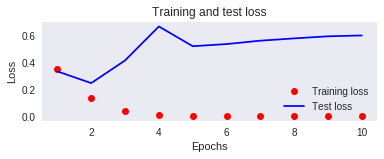

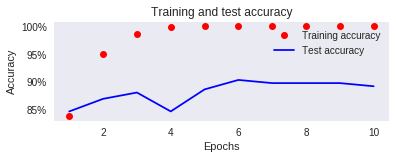

In [0]:
history_dict = history_vgg19.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_vgg19.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_vgg19.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
y_pred = model_vgg19.predict(X_test/np.max(X_train))

In [0]:
np.argsort(np.abs(y_pred.flatten() - y_test))

array([  0,  29, 117,  31, 115,  99,  98,  97,  36,  95,  92,  90, 175,
        41,  86,  82,  79,  78,  73,  47,  72,  51,  52,  66,  61, 125,
       122, 128, 171, 164, 160,   5, 159, 150, 149, 147, 146, 126,  13,
       144,  57,  15, 140, 139, 138, 137,  20, 130,  23,  70,  24, 141,
        14,  22, 170,  63,  69,  88,  58,   6, 172,  62, 104,  84, 167,
       116, 169,   3,  17, 131,  38,  76,  42,   1, 121, 148,  28,  19,
       166, 105, 114, 133, 165,  18,  53,  87, 163, 127, 145,  77, 142,
       153, 102,  21,  34, 154,  49,  65, 129, 110, 152, 151, 100, 132,
       124,  55,  91,  35,  25,   8,  16,  37,  74, 106, 162,  45, 158,
       135,  26,  50,  59, 120, 123,  80,  96,  12, 168,  40,  33,  60,
       157, 174, 155,  54, 111,  81,  48, 118, 112,  43, 156,  11, 103,
        75,  44,  93,   7,  56,  94,  89, 101, 134, 176,  30,  68,  67,
       109, 173, 143, 108,  10,   2,  64, 136,  85,  46,  39, 113,   4,
        27,  83,   9, 119,  71, 107, 161,  32])

In [0]:
y_pred_char = np.where(y_pred>0.5,'M','F')
y_test_char = np.where(y_test==0,'F','M')

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


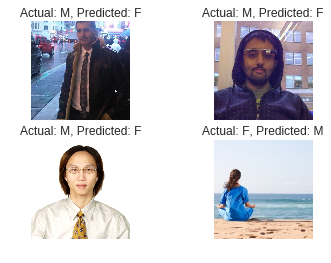

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(221)
plt.imshow(img_test[32])
plt.title('Actual: '+str(y_test_char[32])+', '+'Predicted: '+str((y_pred_char[32][0])))
plt.grid('off')
plt.axis('off')
plt.subplot(222)
plt.title('Actual: '+str(y_test_char[119])+', '+'Predicted: '+str((y_pred_char[119][0])))
plt.imshow(img_test[119])
plt.grid('off')
plt.axis('off')
plt.subplot(223)
plt.title('Actual: '+str(y_test_char[107])+', '+'Predicted: '+str((y_pred_char[107][0])))
plt.imshow(img_test[107])
plt.grid('off')
plt.axis('off')
plt.subplot(224)
plt.title('Actual: '+str(y_test_char[71])+', '+'Predicted: '+str((y_pred_char[71][0])))
plt.imshow(img_test[71])
plt.grid('off')
plt.axis('off')
plt.show()

# Inception v3 architecture

In [0]:
from keras.applications import inception_v3
from keras.applications.inception_v3 import preprocess_input
from keras.utils.vis_utils import plot_model
inception_model = inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(300,300,3))

inception_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_8 (

In [0]:
import cv2
x2 = []
for i in range(len(x)):
    if(i%100 == 0):
      print(i)
    img = x[i]
    img = preprocess_input(img.reshape(1,300,300,3))
    img_new = inception_model.predict(img.reshape(1,300,300,3))
    x2.append(img_new)
	
x2 = np.array(x2)
x2.shape

x2= x2.reshape(x2.shape[0],x2.shape[2],x2.shape[3],x2.shape[4])
x2.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x2,Y, test_size=0.1, random_state=42)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [0]:
model_inception_v3 = Sequential()
model_inception_v3.add(Conv2D(512, kernel_size=(3, 3), activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
model_inception_v3.add(MaxPooling2D(pool_size=(2, 2)))
model_inception_v3.add(Flatten())
model_inception_v3.add(Dense(512, activation='relu'))
model_inception_v3.add(Dropout(0.5))
model_inception_v3.add(Dense(1, activation='sigmoid'))
model_inception_v3.summary()

model_inception_v3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history_inception_v3 = model_inception_v3.fit(X_train/np.max(X_train), y_train, batch_size=16,epochs=10,verbose=1,validation_data = (X_test/np.max(X_train), y_test))	

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 6, 6, 512)         9437696   
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 11,798,017
Trainable params: 11,798,017
Non-trainable params: 0
________________________________________________________________

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


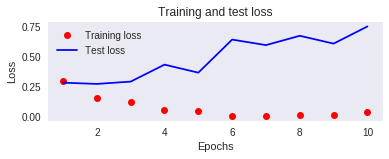

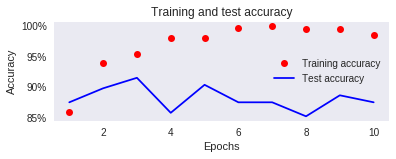

In [0]:
history_dict = history_inception_v3.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_inception_v3.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_inception_v3.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# ResNet 50 architecture

In [0]:
from keras.applications import resnet50
from keras.applications.resnet50 import preprocess_input
resnet50_model = resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(300,300,3))

resnet50_model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
import cv2
x2 = []
for i in range(len(x)):
    if(i%100 == 0):
      print(i)
    img = x[i]
    img = preprocess_input(img.reshape(1,300,300,3))
    img_new = resnet50_model.predict(img.reshape(1,300,300,3))
    x2.append(img_new)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [0]:
x2 = np.array(x2)
x2.shape

(1770, 1, 10, 10, 2048)

In [0]:
x2= x2.reshape(x2.shape[0],x2.shape[2],x2.shape[3],x2.shape[4])
x2.shape

(1770, 10, 10, 2048)

In [0]:
Y = np.array(y2)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x2,Y, test_size=0.1, random_state=42)

In [0]:
model_resnet50 = Sequential()
model_resnet50.add(Conv2D(512, kernel_size=(3, 3), activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
model_resnet50.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet50.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model_resnet50.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(512, activation='relu'))
model_resnet50.add(Dropout(0.5))
model_resnet50.add(Dense(1, activation='sigmoid'))
model_resnet50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 8, 8, 512)         9437696   
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 2, 2, 512)         2359808   
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
__________

In [0]:
model_resnet50.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
np.max(X_train)

119.0767

In [0]:
history_resnet50 = model_resnet50.fit(X_train/np.max(X_train), y_train, batch_size=32,epochs=10,verbose=1,validation_data = (X_test/np.max(X_train), y_test))	

Train on 1593 samples, validate on 177 samples
Epoch 1/10
1593/1593 [==============================] - 8s 5ms/step - loss: 0.3038 - acc: 0.8726 - val_loss: 0.2172 - val_acc: 0.9096
Epoch 2/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.1338 - acc: 0.9492 - val_loss: 0.3677 - val_acc: 0.8757
Epoch 3/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.0668 - acc: 0.9761 - val_loss: 0.2328 - val_acc: 0.9209
Epoch 4/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.0296 - acc: 0.9893 - val_loss: 0.6454 - val_acc: 0.8757
Epoch 5/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.0224 - acc: 0.9956 - val_loss: 0.6950 - val_acc: 0.8814
Epoch 6/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.0389 - acc: 0.9862 - val_loss: 0.3992 - val_acc: 0.9153
Epoch 7/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.0153 - acc: 0.9962 - val_loss: 0.4445 - val_acc: 0.8814
Epoch 8/10
1593

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


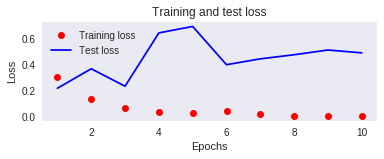

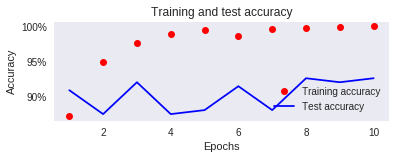

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_resnet50.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_resnet50.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_resnet50.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Visualizing the output intermediate layers

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


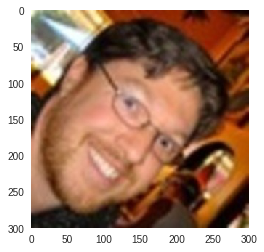

In [0]:
plt.imshow(x[3])
plt.grid('off')

In [0]:
np.max(X_train)

691.86755

In [0]:
from keras.applications.vgg16 import preprocess_input
model_vgg16.predict(vgg16_model.predict(preprocess_input(x[3].reshape(1,300,300,3)))/np.max(X_train))

array([[0.99975926]], dtype=float32)

In [0]:
for layer in vgg16_model.layers:
  print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
from keras import models
activation_model = models.Model(inputs=vgg16_model.input,outputs=vgg16_model.layers[1].output)
activations = activation_model.predict(preprocess_input(x[3].reshape(1,300,300,3)))

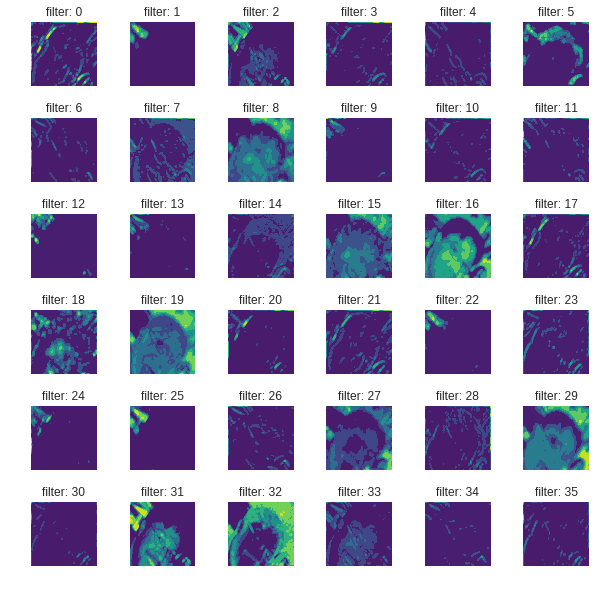

In [0]:
fig, axs = plt.subplots(6, 6, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
first_layer_activation = activations[0]
for i in range(6):
  for j in range(6):
    try:
      axs[i,j].set_ylim((224, 0))
      axs[i,j].contourf(first_layer_activation[:,:,((6*i)+j)],6,cmap='viridis')
      axs[i,j].set_title('filter: '+str((6*i)+j))
      axs[i,j].axis('off')
    except:
      continue

In [0]:
activation_model = models.Model(inputs=vgg16_model.input,outputs=vgg16_model.layers[1].output)
activations = activation_model.predict(preprocess_input(np.array(x[:36]).reshape(36,300,300,3)))

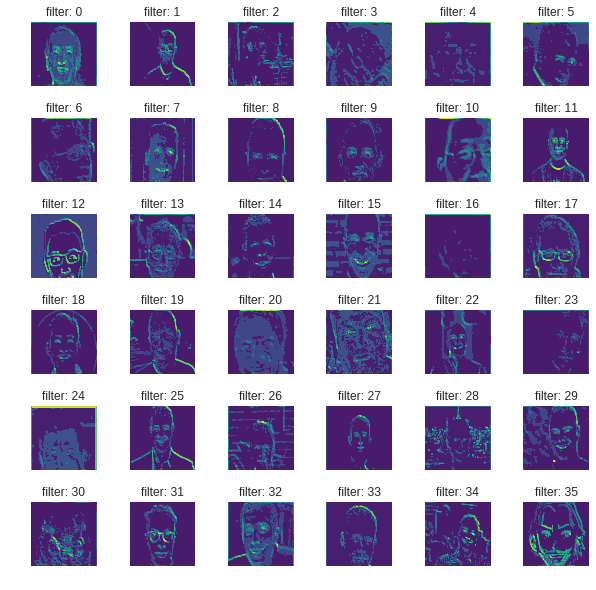

In [0]:
fig, axs = plt.subplots(6, 6, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
first_layer_activation = activations
for i in range(6):
  for j in range(6):
    try:
      axs[i,j].set_ylim((224, 0))
      axs[i,j].contourf(first_layer_activation[((6*i)+j),:,:,7],6,cmap='viridis')
      axs[i,j].set_title('filter: '+str((6*i)+j))
      axs[i,j].axis('off')
    except:
      continue

In [0]:
activation_model = models.Model(inputs=vgg16_model.input,outputs=vgg16_model.layers[-1].output)
activations = activation_model.predict(preprocess_input(x[3].reshape(1,300,300,3)))

In [0]:
last_layer_activation.shape

(1, 9, 9, 512)

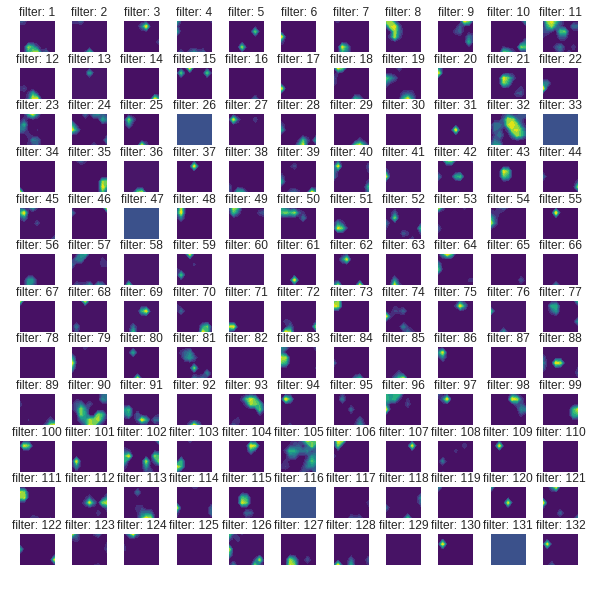

In [0]:
fig, axs = plt.subplots(12, 11, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)

last_layer_activation = activations
count = 0
for i in range(12):
  for j in range(11):
    try:
      count+=1
      axs[i,j].set_ylim((6, 0))
      axs[i,j].contourf(last_layer_activation[0,:,:,((12*i)+j)],11,cmap='viridis')
      axs[i,j].set_title('filter: '+str(count))
      axs[i,j].axis('off')
    except:
      continue